# Final Project - Titanic Dataset
Author: Graydon Hall


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions

In [4]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_pred, y_actual, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    mat = confusion_matrix(y_actual, y_pred)
    ax = plt.axes()
    sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, 
                fmt='g', square=True, annot=True, cbar=False, ax=ax)

    plt.xlabel('predicted value')
    plt.ylabel('true value')
    ax.set_title(title)

    
   

In [5]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model, X, y, return_train_score=True, cv=cv, scoring=scoring)
    return scores['train_score'].mean(), scores['test_score'].mean()
    

In [6]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    
    print(grid_search.best_params_)
    traning_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
    test_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
    print(f"training_score={traning_score:.3f}; validation score={test_score:.3f}")
    

In [7]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

## 1. Load the titanic dataset

In [8]:
# load in our training and testing data
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")  # data is unlabelled

# train = train[train['Age'].notna()] # drop rows where age is null

y = train['Survived']
X = train.drop(['Survived'], axis=1)

In [9]:
# inspect our feature matrix
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
# inspect our target vector
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [11]:
# drop columns which are not relevant to the study
# Name, PassengerId, Ticket, Embarked, Cabin (cabin #)
X = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
X

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000
887,1,female,19.0,0,0,30.0000
888,3,female,NaN,1,2,23.4500
889,1,male,26.0,0,0,30.0000


## 2. Inspect the data through visualizations

Going to get a count plot for our categorical classes of Pclass, and Sex, to see if any trend in who lived emerges

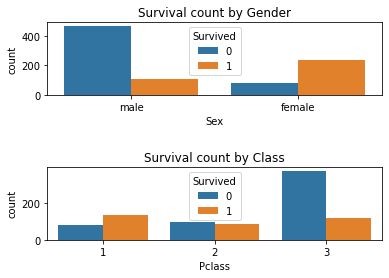

In [12]:
# Add countplots for each feature.
fig, (ax1, ax2) = plt.subplots(nrows=2)
sns.countplot(x='Sex', data=X, hue=y, ax=ax1).set(title="Survival count by Gender")
sns.countplot(x='Pclass', data=X, hue=y, ax=ax2).set(title="Survival count by Class")
plt.subplots_adjust(hspace = 1)

Trends we see from these plots
* females were more likely to survive
* similar numbers survived for each class
* number of deaths were much higher for 3rd class though

Next we make a histogram plot for survival based on age

[Text(0.5, 1.0, 'Survival Histogram based on Age')]

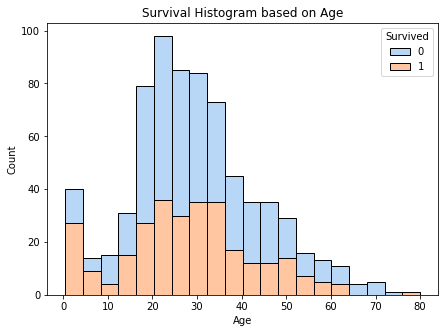

In [13]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

# plot
import seaborn as sns
sns.histplot(data=train, ax=ax, stat="count", multiple="stack",
             x="Age", kde=False,
             palette="pastel", hue="Survived",
             element="bars", legend=True).set(title="Survival Histogram based on Age")

From this, we see a clear trend where those who are younger survive at a higher rate.

Next we plot parch (# of parents / children aboard the Titanic) and sibsp (# of siblings / spouses aboard the Titanic) in a similar manner to see if any trends arise

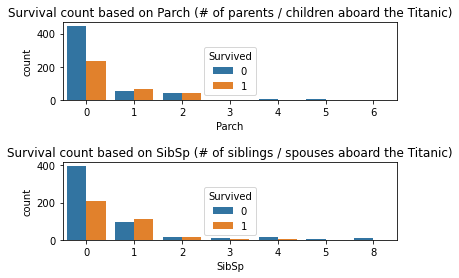

In [14]:
# Add countplots for each feature.
fig, (ax1, ax2) = plt.subplots(nrows=2)
sns.countplot(x='Parch', data=X, hue=y, ax=ax1).set(title = "Survival count based on Parch (# of parents / children aboard the Titanic)")
sns.countplot(x='SibSp', data=X, hue=y, ax=ax2).set(title = "Survival count based on SibSp (# of siblings / spouses aboard the Titanic)")
plt.subplots_adjust(hspace = 0.8)

An interesting trend arises here, where those who have 1 sibling/spouse, or who have one parent/child seem to survive at a higher rate. Some possible explanations: 
* Since we know women survive at a higher rate, the higher survival rate of those SibSp = 1 may be explained by husband wife pairs, where the wife is more likely to survive
* We know children survive at a higher rate, and that children are most likely travelling alone, therefore the higher survival rate of those with parch >1 is most likely due to the higher survival rate of children
* To avoid having these trends captured by multiple features, we will drop the Parch and SibSp columns

In [15]:
X = X.drop(['Parch', 'SibSp'], axis=1)
X

,Pclass,Sex,Age,Fare
0,3,male,22.0,7.2500
1,1,female,38.0,71.2833
2,3,female,26.0,7.9250
3,1,female,35.0,53.1000
4,3,male,35.0,8.0500
...,...,...,...,...
886,2,male,27.0,13.0000
887,1,female,19.0,30.0000
888,3,female,NaN,23.4500
889,1,male,26.0,30.0000


## 3. Preprocessing

### 3.1 Encoding of features
Will apply encoding to our male and female columns

In [16]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(X[['Sex']])
X['gender'] = enc.transform(X[['Sex']])
X = X.drop(['Sex'], axis=1)
X
# ladies = 0, male = 1

,Pclass,Age,Fare,gender
0,3,22.0,7.2500,1.0
1,1,38.0,71.2833,0.0
2,3,26.0,7.9250,0.0
3,1,35.0,53.1000,0.0
4,3,35.0,8.0500,1.0
...,...,...,...,...
886,2,27.0,13.0000,1.0
887,1,19.0,30.0000,0.0
888,3,NaN,23.4500,0.0
889,1,26.0,30.0000,1.0


In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)  # can use all data since it's just for visualization purposes
scaled_features = scaler.transform(X)

X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

Inspect for null values (*used in initial version where we try filling null values for age with the mean of age instead of just dropping null column values. In section 6 we demonstrate that dropping null values instead of filling with the mean of the column produces better results*)

In [18]:
print(X.isna().sum())  # shows us we have 177 null ages
X['Age'].fillna((X['Age'].mean()), inplace=True)

Pclass      0
Age       177
Fare        0
gender      0
dtype: int64


## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets.

In [19]:
# TODO: add train_test_split() here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=37, test_size=0.2)

## 5. Compare models using cross-validation
We a list containing a `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier()`, 
         `GradientBoostingClassifier(random_state=56)` objects.

We then iterate through this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

We use our training data and 7-fold cross-validation.

In [351]:
# TODO: add cross-validation comparison here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
r_state = 55

models = [LogisticRegression(random_state=r_state), SVC(random_state=r_state), BernoulliNB(), RandomForestClassifier(random_state=r_state), GradientBoostingClassifier(random_state=r_state)]
results = []
for model in models:
    train_score, validation_score= get_classifier_cv_score(model, X_train, y_train, scoring='average_precision')
    result = (validation_score,f"{model} train_score={train_score:.3f} validation_score={validation_score:.3f}")
    results.append(result)

results.sort(key=lambda y: y[0], reverse=True)
for result in results:
    print(result[1])

GradientBoostingClassifier(random_state=55) train_score=0.935 validation_score=0.827
SVC(random_state=55) train_score=0.835 validation_score=0.815
LogisticRegression(random_state=55) train_score=0.807 validation_score=0.813
RandomForestClassifier(random_state=55) train_score=0.996 validation_score=0.808
BernoulliNB() train_score=0.778 validation_score=0.772


### Summary of Results 
The results of this secion are provided in the following table, with Nulls dropped and with nulls replaced with mean<br>
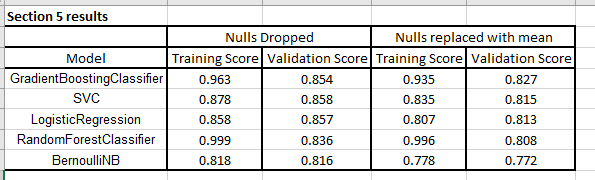<br>
From this, it would appear that dropping the Null rows produces the best results. However, this result will be questioned and explored in greater detail in seciction 7, where the actual testing data is used

## 6. Hyperparameter tuning using grid search
We are going to try to perform hyper parameter tuning by applying grid search to our GradientBoostingClassifier, RandomForestClassifier, and SVC. Although random forest had a lower validation score than Logistic Regression, it's extremely high training score makes it an intriguing model to try and tune and improve


### 6.1 Grid search for RandomForestClassifier 
First, we perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

In [352]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 150, 300, 500],
             'max_depth': [1, 3, 5, 7]}

grid1 = GridSearchCV(RandomForestClassifier(random_state=55), param_grid, cv=7, n_jobs=-1, scoring='average_precision', return_train_score=True)

In [353]:
# TODO: perform the grid search by calling fit()
grid1.fit(X_train, y_train)   

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7],
                         'n_estimators': [50, 100, 150, 300, 500]},
             return_train_score=True, scoring='average_precision')

In [354]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid1)

{'max_depth': 5, 'n_estimators': 100}
training_score=0.905; validation score=0.844


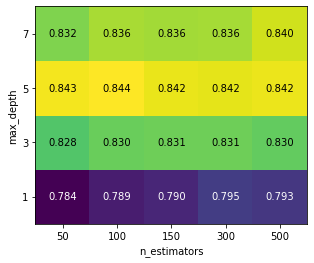

In [355]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid1)

### 6.2 Gradient boosting classifier 
Next, we perform grid search using `GridSearchCV` for the `GradientBoostingClassifier()` using a similar process

In [356]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 400],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
             'max_depth': [1,3,5,7,9]}

grid2 = GridSearchCV(GradientBoostingClassifier(random_state=56), param_grid, cv=7, n_jobs=-1, scoring='average_precision', return_train_score=True)

In [357]:
# TODO: perform the grid search by calling fit()
grid2.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=56),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [50, 100, 200, 400]},
             return_train_score=True, scoring='average_precision')

In [358]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid2)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
training_score=0.957; validation score=0.834


### 6.3 SVC classifier 
Next, we perform grid search using `GridSearchCV` for the `SVC()` using a similar process

In [359]:
param_grid = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              'kernel':['linear', 'rbf']}
grid3 = GridSearchCV(SVC(random_state=55), param_grid, cv=7, n_jobs=-1, scoring='average_precision', return_train_score=True)

In [360]:
# TODO: perform the grid search by calling fit()
grid3.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(random_state=55), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='average_precision')

In [361]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid3)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
training_score=0.859; validation score=0.827


### Section 6 results summarized
Note: null values are replaced with the mean, as it is demonstrated at the end of the lab this is the optimal strategy for getting the best results on the testing data.
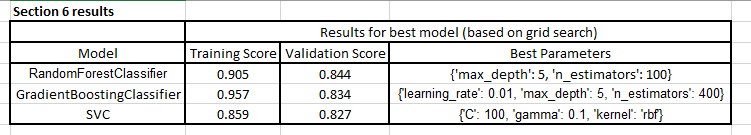

# 7. Testing out CatBoost, XGBoost, and our tuned Gradient boosting classifier and Random Forest models

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       448
           1       0.93      0.76      0.84       264

    accuracy                           0.89       712
   macro avg       0.90      0.86      0.88       712
weighted avg       0.89      0.89      0.89       712

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       101
           1       0.88      0.74      0.81        78

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.84      0.84       179



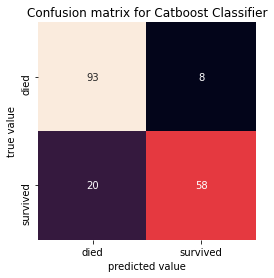

In [362]:
# catboost
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
cat_boost = CatBoostClassifier(verbose=False)
cat_boost.fit(X_train, y_train)

y_pred_train_cb = cat_boost.predict(X_train)
print(classification_report(y_train, y_pred_train_cb))
 
y_pred_test_cb = cat_boost.predict(X_test)
print(classification_report(y_test, y_pred_test_cb))
plot_confusion_matrix(y_pred_test_cb, y_test, labels=['died', 'survived'] ,title='Confusion matrix for Catboost Classifier')

[22:26:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       448
           1       0.97      0.91      0.94       264

    accuracy                           0.96       712
   macro avg       0.96      0.94      0.95       712
weighted avg       0.96      0.96      0.95       712

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       101
           1       0.82      0.79      0.81        78

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



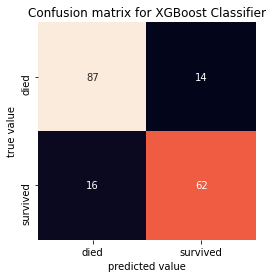

In [363]:
# xgboost
from xgboost import XGBClassifier
xg_boost = XGBClassifier(use_label_encoder=False)
xg_boost.fit(X_train, y_train)

y_pred_train_xgb = xg_boost.predict(X_train)
print(classification_report(y_train, y_pred_train_xgb))
 
y_pred_test_xgb = xg_boost.predict(X_test)
print(classification_report(y_test, y_pred_test_xgb))
plot_confusion_matrix(y_pred_test_xgb, y_test, labels=['died', 'survived'] ,title='Confusion matrix for XGBoost Classifier')

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       448
           1       0.97      0.89      0.93       264

    accuracy                           0.95       712
   macro avg       0.96      0.94      0.95       712
weighted avg       0.95      0.95      0.95       712

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       101
           1       0.86      0.78      0.82        78

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



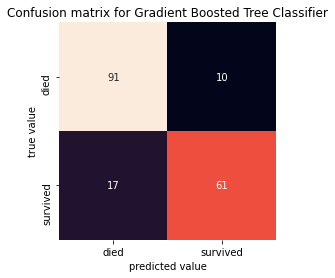

In [364]:
# Gradient boosted classifier
gbt = GradientBoostingClassifier(random_state=56, learning_rate = 0.1, max_depth=5, n_estimators=100)
gbt.fit(X_train, y_train)

y_pred_train_gbt = gbt.predict(X_train)
print(classification_report(y_train, y_pred_train_gbt))

y_pred_test_gbt = gbt.predict(X_test)
print(classification_report(y_test, y_pred_test_gbt))
plot_confusion_matrix(y_pred_test_gbt, y_test, labels=['died', 'survived'] ,title='Confusion matrix for Gradient Boosted Tree Classifier')

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       448
           1       0.97      0.89      0.93       264

    accuracy                           0.95       712
   macro avg       0.96      0.94      0.95       712
weighted avg       0.95      0.95      0.95       712

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       101
           1       0.86      0.78      0.82        78

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



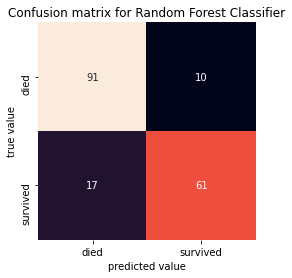

In [365]:
# Random Forest
rf = RandomForestClassifier(random_state=55, max_depth=5, n_estimators= 500)
rf.fit(X_train, y_train)

y_pred_train_rf = gbt.predict(X_train)
print(classification_report(y_train, y_pred_train_rf))

y_pred_test_rf = gbt.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))
plot_confusion_matrix(y_pred_test_rf, y_test, labels=['died', 'survived'] ,title='Confusion matrix for Random Forest Classifier')

### Section 7 Results summarized:
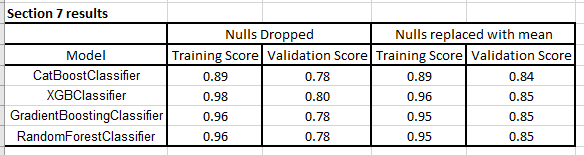<br>
* note that due to randomness, some results in the table may differ from results shown by +/- 0.01

# 8. Analysis on how to handle null ages

An interesting dilemma arises with this dataset. We have 890 values, and 177 rows with null ages. This is an issue, since age is a particulary predictive feature. We have 2 options we tested. 
1. Drop rows with null  values (done by including `train = train.dropna()` in step 1.1)
2. Fill null ages with the mean age

Interestingly enough, when we drop the rows with null values, we get better results in section 5 when performing cross validation:<br>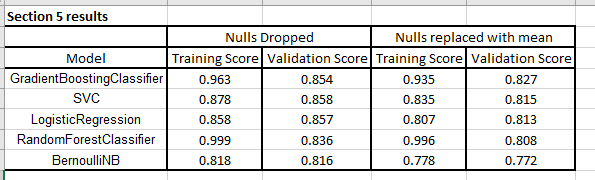<br>

However, in Section 7 we get better results on the testing data when the Null values are replaced with the mean age instead<br>
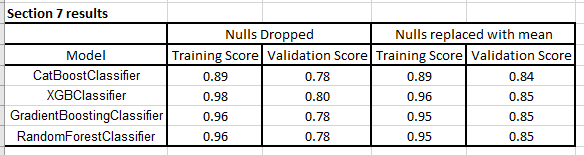<br>
Therefore it is concluded that replacing null values for age with the mean age is the best strategy.

# 9. Visualzing the data using PCA

Original shape: (891, 4)
Reduced shape: (891, 2)


Text(0.5, 1.0, 'PCA analysis for Titanic Dataset')

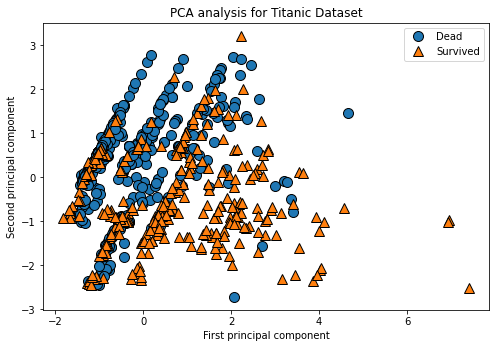

In [23]:
from sklearn.decomposition import PCA

# apply standard scaler first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)  # can use all data since it's just for visualization purposes
X_scaled = scaler.transform(X)
X_scaled

# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

# Taken things down from 30 features to 2 features
# Original shape: (891, 4)
# Reduced shape: (891, 2)


plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], y)
plt.legend(['Dead', 'Survived'], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("PCA analysis for Titanic Dataset")

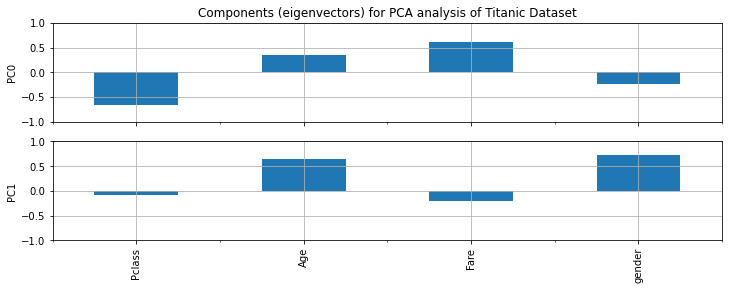

In [24]:
# investigating how each component contributes to each PC Axis
p_components = pd.DataFrame(pca.components_, columns=X.columns)
f, axs = plt.subplots(p_components.shape[0], 1, figsize=(12,4),sharex=True)
for i, ax in enumerate(axs):
    p_components.loc[i,:].plot.bar(ax=ax)
    ax.set_ylabel('PC{}'.format(i))
    ax.set_ylim([-1,1])
    ax.grid(True)
axs[0].set_title('Components (eigenvectors) for PCA analysis of Titanic Dataset');

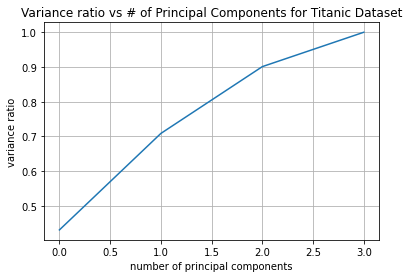

In [25]:
pca_all = PCA()
pca_all.fit(X_scaled)
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('number of principal components')
plt.ylabel('variance ratio')
plt.title('Variance ratio vs # of Principal Components for Titanic Dataset')
plt.grid(True)

### Discussion on PCA Analysis on titanic dataset
* Using PCA and plotting our 2 axis we are able to see a slight trend in who survived, though the analysis is not overly effective
* By plotting the variance ratio vs the number of principal component axis, we see that using 2 principal components, we are only able to explain 70% of the variance, hence explaining why our visualization is not overly effective

# 10. Feature Importances

In [369]:
# code to find feature importances
print(X.columns)
print(gbt.feature_importances_)

Index(['Pclass', 'Age', 'Fare', 'gender'], dtype='object')
[0.1583209  0.21059182 0.26824715 0.36284012]


Text(0.5, 1.0, 'Feature importances for titanic dataset')

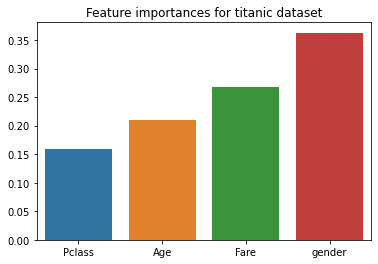

In [370]:
ax = sns.barplot(x=X.columns, y=gbt.feature_importances_)
ax.set_title('Feature importances for titanic dataset')

# Summary of Report by Section

### 0. Function definitions
* In this section, the following functions were defined in order to streamline the analysis process in the lab
    * `plot_confusion_matrix()`: plots a confusion matrix based on y_predicted vs y_true
    * `get_classifier_cv_score()`: gets cross validation score for a classifier
    * `print_grid_search_result()`: for best model from a GridSearchCV object, this prints the parameters, and cross validation training and test score
    * `plot_grid_search_results()` - For grids with 2 hyperparameters, create a heatmap plot of test scores

### 1. Load the titanic dataset
* In this section, we simply load in the titanic dataset
* We drop the following comments off the bat, since they will not be meaningful in our analysis: PassengerId, Name, Ticket, Cabin, Embarked
* For our analysis, in the case of handling the 177 Null age values by simply dropping those rows, that step is performed here.

### 2. Inspect the data through visualizations
Three visualizations were created in this section. Each of them are presented below, along with the conclusions gained from them<br>
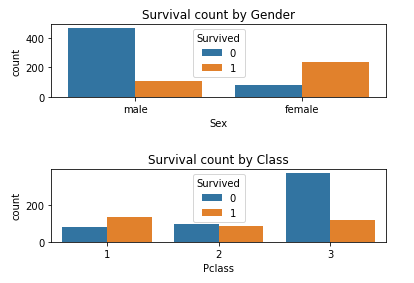<br>
Trends we see from these above 2 plots
* females were more likely to survive
* similar numbers survived for each class
* number of deaths were much higher for 3rd class though<br> 
***

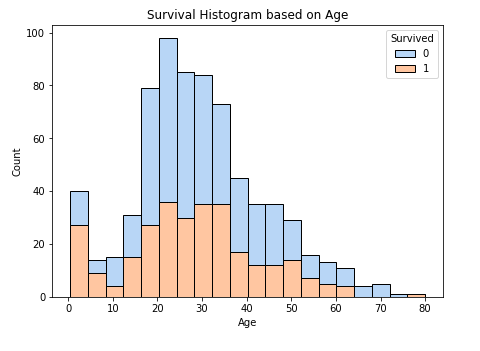<br>
* From this, we see a clear trend where those who are younger survive at a higher rate.<br>
*** 

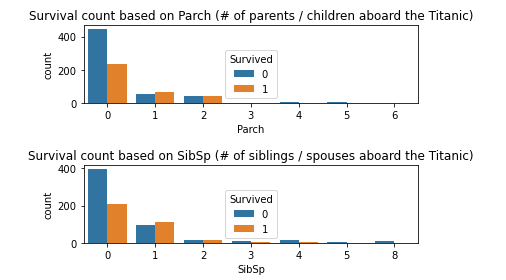<br>
* An interesting trend arises here, where those who have 1 sibling/spouse, or who have one parent/child seem to survive at a higher rate. Some possible explanations: 
    * Since we know women survive at a higher rate, the higher survival rate of those SibSp = 1 may be explained by husband wife pairs, where the wife is more likely to survive
    * We know children survive at a higher rate, and that children are most likely travelling alone, therefore the higher survival rate of those with parch >1 is most likely due to the higher survival rate of children
    * To avoid having these trends captured by multiple features, we will drop the Parch and SibSp columns

### 3. Preprocessing
* First, we encode Male and Female into numerical values (ladies = 0, male = 1)
* StandardScaler is then applied to the dataframe, since it is required for some of our classifiers, and will not negatively affect the others who don't technically require it
* For our analysis, in the case of handling the 177 Null age values by filling them with the mean age of the dataset, this is done here. 

### 4. Create training and test sets
* The dataset is split into training and testing data using `train_test_split()`
* 20% of the data is designated for the test set

### 5. Compare models using cross-validation
* We create a list containing a `LogisticRegression()`, `SVC()`, `BernoulliNB()`, `RandomForestClassifier()`, `GradientBoostingClassifier()` objects.

- We then iterate through this list, then:
    - compute the **average precision** using `get_classifier_cv_score()` defined in step 0, 
    - rank the models based on validation **average precision** (best first),
    - and print the ranked models training and validation scores with **3 decimal places**. 
    - We use our training data and 7-fold cross-validation.<br><br>
    
- The results are summarized in the following figure:<br> 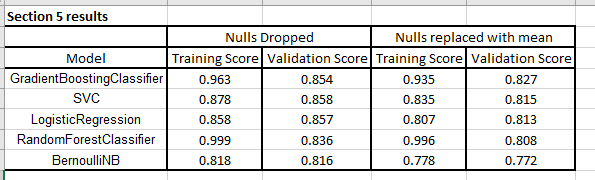<br>
- From this, it would appear that dropping the Null rows produces the best results. 
- However, this result is questioned and explored in greater detail in seciction 7, where the actual testing data is used.
- Based on these results, we perform hyper parameter tuning by applying grid search to our `GradientBoostingClassifier`, `RandomForestClassifier`, and `SVC` in step 6. 
- Although random forest had a lower validation score than Logistic Regression, it's extremely high training score makes it an intriguing model to try and tune and improve


### 6. Hyperparameter tuning using grid search
* We erform hyper parameter tuning by applying grid search to our `GradientBoostingClassifier`, `RandomForestClassifier`, and `SVC`.
* The results are summarized in the following table (Note: these scores are based on null values being replaced with the mean, as it is demonstrated in Part 7 of the lab this is the optimal strategy for getting the best results on the testing data)<br>
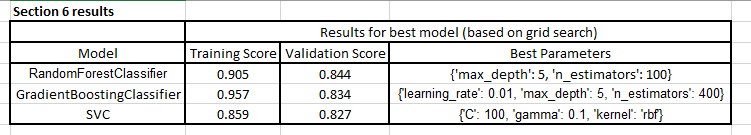<br>


### 7. Testing out CatBoost, XGBoost, and our best tuned models (GradientBoostingClassifier and RandomForestClassifier)
* in this section, we test out the CatBoost, XGBoost, and our best tuned model (GradientBoostingClassifier and RandomForestClassifier)
* In this section we perform the the training with rows with null ages removed *and* null ages replaced with mean age.
* This information is used in step 8, where we concclude the best strategy for handling the null ages<br>
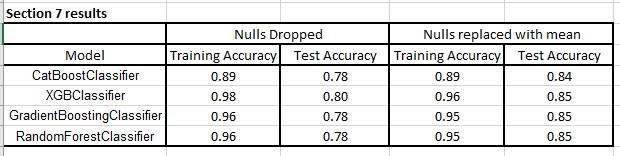<br>
* Interestingly enough, Three of the models tie in terms of Validation score
* Therefore, the best classifier for this dataset is a tie between **GradientBoostingClassifier, RandomForestClassifier , and XGBoost.** 

### 8. Analysis on how to handle null ages
An interesting dilemma arises with this dataset. We have 890 values, and 177 rows with null ages. This is an issue, since age is a particulary predictive feature. We have 2 options we tested. 
1. Drop rows with null  values (done by including `train = train.dropna()` in step 1.1)
2. Fill null ages with the mean age (done in step 3)

Interestingly enough, when we drop the rows with null values, we get better results in section 5 when performing cross validation:<br>
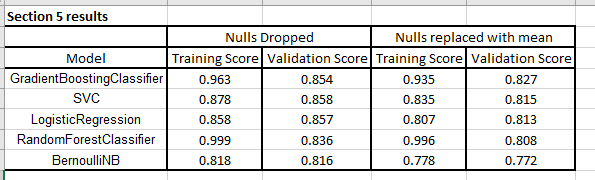<br>

However, in Section 7 we get better results on the testing data when the Null values are replaced with the mean age instead<br>
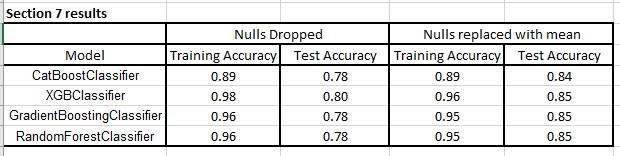<br>
Therefore it is concluded that **replacing null values for age with the mean age is the best strategy for handling null ages**

### 9. Visualzing the data using PCA
* In this section, we perform a PCA analysis to examine if the applying PCA might give us a nice way to visualize the data<br>
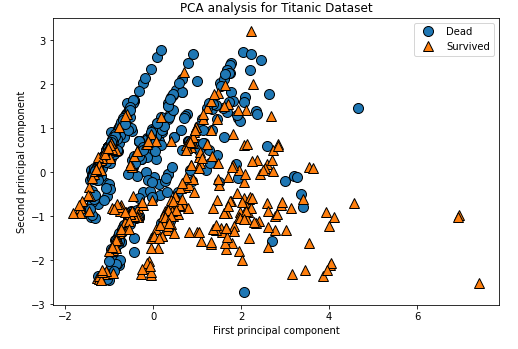<br>
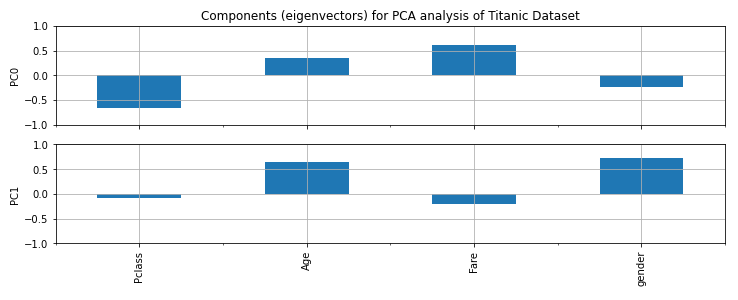<br>
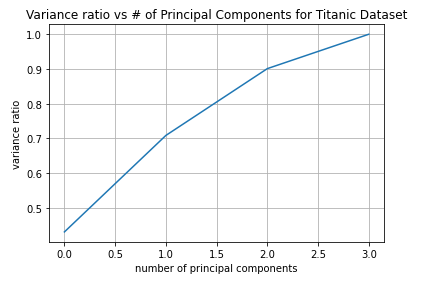<br>
* Using PCA and plotting our 2 axis we are able to see a slight trend in who survived, though the analysis is not overly effective
* By plotting the variance ratio vs the number of principal component axis, we see that using 2 principal components, we are only able to explain 70% of the variance, hence explaining why our visualization is not overly effective

### 10. Feature Importances
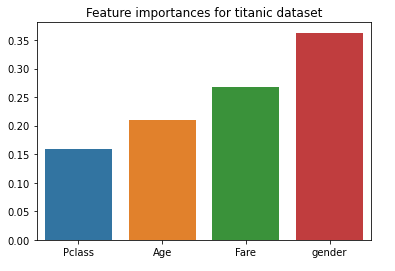<br>
* Analyzing this diagram, we see that all the features we ended up using are relatively important
* This confirms our conclusions we drew in section 2.
* We can explain the importance of each feature as follows
    * **Gender**: important since woment were more likely to survive
    * **Age**: Important since children were more likely to survive
    * **Class and Fare**: important since those in higher classers were more likely to survive

# Summary of Questions Answered/Topics Investigated
### 1. Which model will produce the best results on the testing data
* The top 4 models are given in the following table<br>
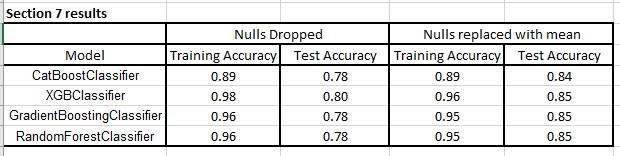<br>
* Interestingly enough, Three of the models tie in terms of Validation score
* Therefore, the best classifier for this dataset is a tie between **GradientBoostingClassifier, RandomForestClassifier , and XGBoost.** 

### 2. Investigating the use of PCA to try and visualize 
* The result of trying to visualize things using 2 Principal Component Axis are given in the following figure. <br>
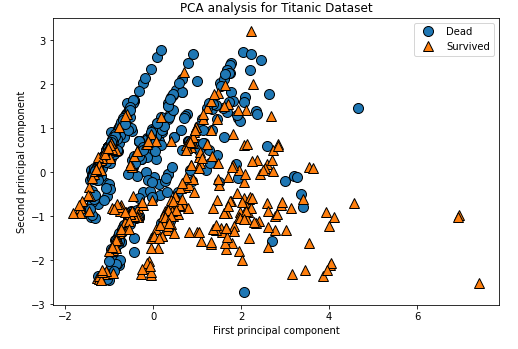
* Given that all 4 features are quite important in predicting the outcome of survival, it is concluded that using PCA to visualize who survived and did not is not an overly effective tool on this dataset.

### 3. Which featuers are most predictive in this model, and which can be ignored? 
* The following 4 features that we ended up using are: <br>
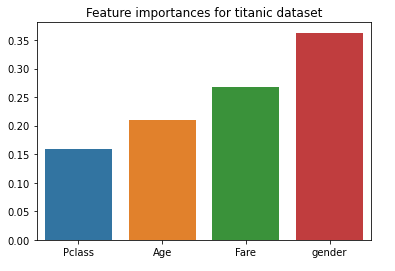<br>
* All 4 features are important in predicting the survival outcome of the passengers
* Through analysis performed in the lab, the features that were deemed non-important and were therefore disgarded were: PassengerId, Name, Ticket, Cabin, Embarked, Parch, SibSp

### 4. What is the best strategy for handling the null values which show up in the age column
* Through analysis in the lab, it was determined that **replacing the 177 null Ages with the mean age of the dataset yielded the highest accuracies on the testing data**